In [1]:
!pip install mplfinance
!pip install lightgbm
!pip install tensorflow

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import mplfinance as mpf
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from statsmodels.tsa.stattools import adfuller

In [3]:
df_sol = pd.read_csv(r"C:\Users\dmade\Downloads\archive (10)\solusd_dataset.csv")

df_sol.head(5)

,Unnamed: 0,Date,Open,High,Low,Close
0,0,2020-04-10 00:00:00+00:00,0.832005,1.313487,0.694187,0.951054
1,1,2020-04-11 00:00:00+00:00,0.951054,1.049073,0.765020,0.776819
2,2,2020-04-12 00:00:00+00:00,0.785448,0.956670,0.762426,0.882507
3,3,2020-04-13 00:00:00+00:00,0.890760,0.891603,0.773976,0.777832
4,4,2020-04-14 00:00:00+00:00,0.777832,0.796472,0.628169,0.661925


In [4]:
df_sol.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1862 entries, 0 to 1861
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  1862 non-null   int64  
 1   Date        1862 non-null   object 
 2   Open        1862 non-null   float64
 3   High        1862 non-null   float64
 4   Low         1862 non-null   float64
 5   Close       1862 non-null   float64
dtypes: float64(4), int64(1), object(1)
memory usage: 87.4+ KB


In [5]:
df_sol.shape

(1862, 6)

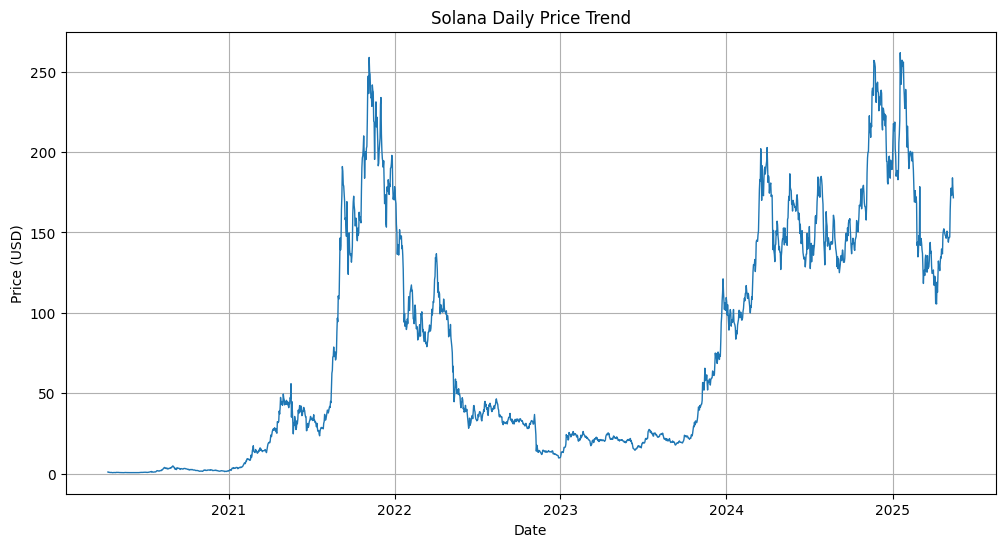

In [6]:
plt.figure(figsize=(12, 6))
plt.plot(pd.to_datetime(df_sol['Date']), df_sol['Close'], linewidth=1)
plt.title('Solana Daily Price Trend')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.grid(True)
plt.show()

Basic Statistics for Solana Price:
              Open         High          Low        Close
count  1862.000000  1862.000000  1862.000000  1862.000000
mean     75.597519    78.613872    72.614401    75.672646
std      71.044621    73.612218    68.349786    71.031936
min       0.513391     0.559759     0.505194     0.515273
25%      19.246758    19.721948    18.854750    19.268242
50%      39.127583    41.113768    37.515196    39.098019
75%     139.534615   144.808777   134.507732   139.659554
max     261.872437   294.334961   253.187439   261.869751

Annualized Volatility: 106.10%

Return Distribution Characteristics:
Skewness: 0.54
Kurtosis: 5.48


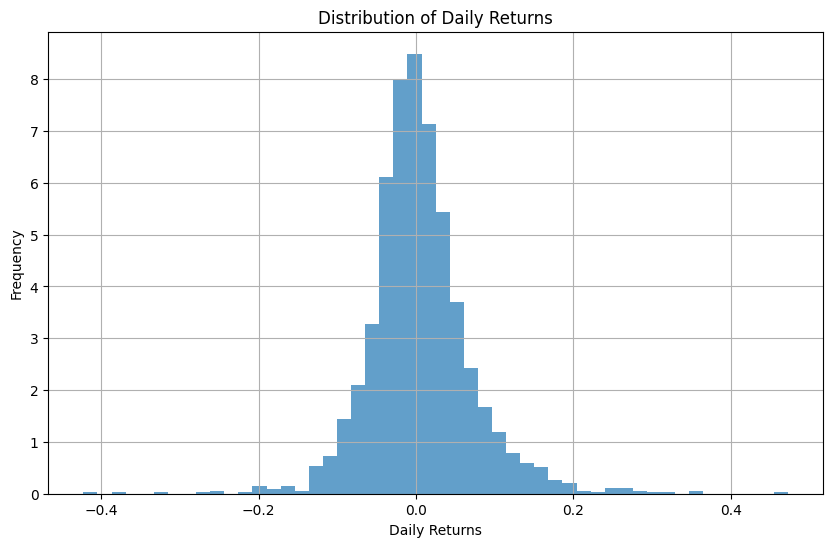

In [7]:
# Calculate basic statistics for price data
print("Basic Statistics for Solana Price:")
print(df_sol[['Open', 'High', 'Low', 'Close']].describe())

# Calculate daily returns
df_sol['Daily_Return'] = df_sol['Close'].pct_change()

# Calculate volatility (standard deviation of returns)
volatility = df_sol['Daily_Return'].std() * np.sqrt(252)  # Annualized volatility
print("\nAnnualized Volatility:", f"{volatility:.2%}")

# Calculate skewness and kurtosis of returns
skewness = df_sol['Daily_Return'].skew()
kurtosis = df_sol['Daily_Return'].kurtosis()
print("\nReturn Distribution Characteristics:")
print(f"Skewness: {skewness:.2f}")
print(f"Kurtosis: {kurtosis:.2f}")

# Create a histogram of daily returns
plt.figure(figsize=(10, 6))
df_sol['Daily_Return'].hist(bins=50, density=True, alpha=0.7)
plt.title('Distribution of Daily Returns')
plt.xlabel('Daily Returns')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [8]:
# Calculate maximum drawdown
def calculate_max_drawdown(prices):
    peak = prices.expanding(min_periods=1).max()
    drawdown = (prices - peak) / peak
    max_drawdown = drawdown.min()
    return max_drawdown

max_drawdown = calculate_max_drawdown(df_sol['Close'])

# Calculate other relevant metrics
positive_returns = (df_sol['Daily_Return'] > 0).mean() * 100
negative_returns = (df_sol['Daily_Return'] < 0).mean() * 100

print("Additional Risk Metrics:")
print(f"Maximum Drawdown: {max_drawdown:.2%}")
print(f"Percentage of Positive Days: {positive_returns:.1f}%")
print(f"Percentage of Negative Days: {negative_returns:.1f}%")

# Calculate price movement statistics
print("\nPrice Movement Statistics:")
print(f"All-Time High: ${df_sol['High'].max():.2f}")
print(f"All-Time Low: ${df_sol['Low'].min():.2f}")
print(f"Current Price: ${df_sol['Close'].iloc[-1]:.2f}")
print(f"Price Range: ${df_sol['High'].max() - df_sol['Low'].min():.2f}")

Additional Risk Metrics:
Maximum Drawdown: -96.27%
Percentage of Positive Days: 49.9%
Percentage of Negative Days: 50.1%

Price Movement Statistics:
All-Time High: $294.33
All-Time Low: $0.51
Current Price: $171.63
Price Range: $293.83


In [9]:
# Basic data exploration
print("Dataset Information:")
print("\nMissing Values:")
print(df_sol.isnull().sum())


Dataset Information:

Missing Values:
Unnamed: 0      0
Date            0
Open            0
High            0
Low             0
Close           0
Daily_Return    1
dtype: int64


In [10]:
# Drop the single missing value in Daily_Return (first row where pct_change() produces NaN)
df_sol = df_sol.dropna()

print("Dataset after cleaning:")
print("\nMissing Values:")
print(df_sol.isnull().sum())
print("\nDataset Shape:", df_sol.shape)

Dataset after cleaning:

Missing Values:
Unnamed: 0      0
Date            0
Open            0
High            0
Low             0
Close           0
Daily_Return    0
dtype: int64

Dataset Shape: (1861, 7)


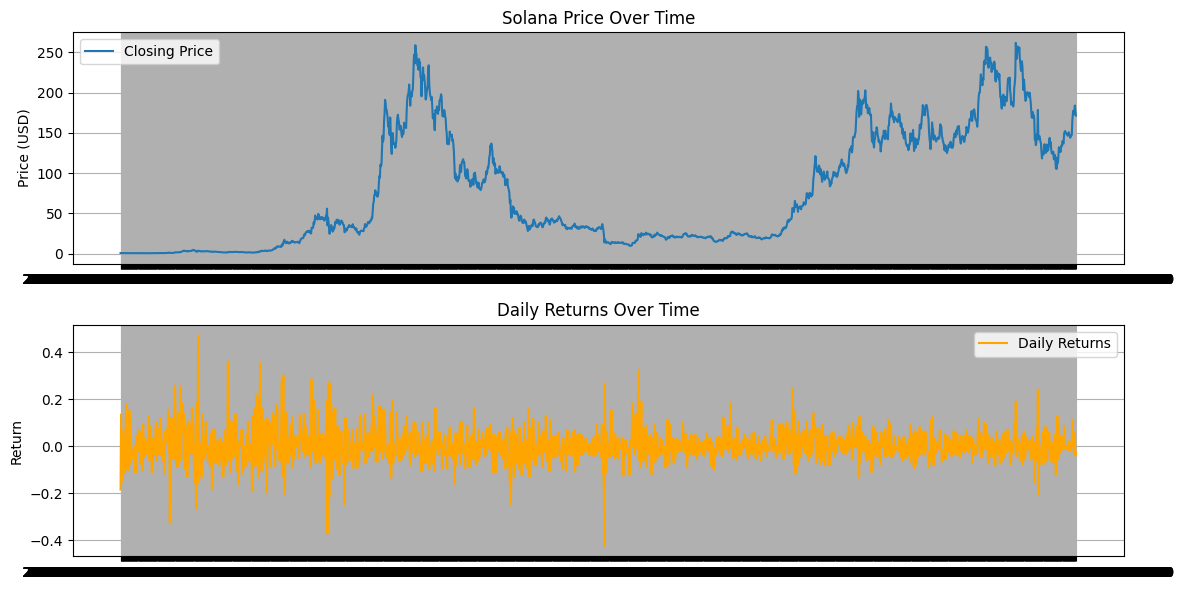

In [11]:
# Temporal analysis
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(df_sol['Date'], df_sol['Close'], label='Closing Price')
plt.title('Solana Price Over Time')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(df_sol['Date'], df_sol['Daily_Return'], label='Daily Returns', color='orange')
plt.title('Daily Returns Over Time')
plt.ylabel('Return')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

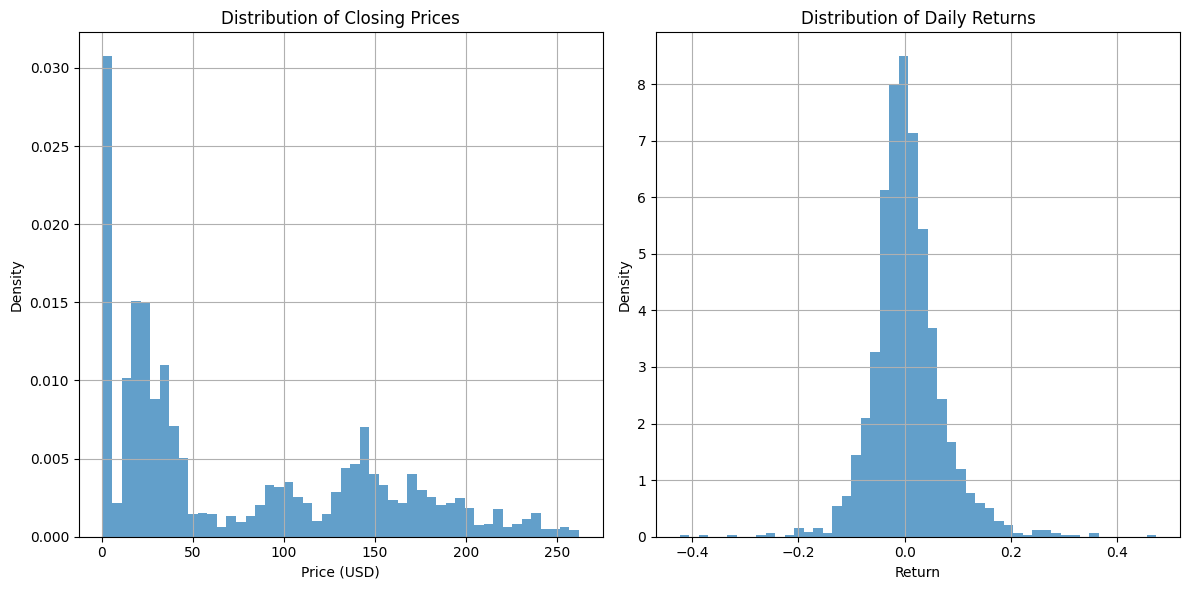


Correlation Matrix:
                  Open      High       Low     Close  Daily_Return
Open          1.000000  0.998704  0.998438  0.997259     -0.060270
High          0.998704  1.000000  0.998015  0.998879     -0.034521
Low           0.998438  0.998015  1.000000  0.998479     -0.037287
Close         0.997259  0.998879  0.998479  1.000000     -0.013532
Daily_Return -0.060270 -0.034521 -0.037287 -0.013532      1.000000

Volatility (Standard deviation of returns): 0.06683585980392023
Skewness of returns: 0.5381384615208212
Kurtosis of returns: 5.484664362447525


In [12]:
# Distribution analysis
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
df_sol['Close'].hist(bins=50, density=True, alpha=0.7)
plt.title('Distribution of Closing Prices')
plt.xlabel('Price (USD)')
plt.ylabel('Density')
plt.grid(True)

plt.subplot(1, 2, 2)
df_sol['Daily_Return'].hist(bins=50, density=True, alpha=0.7)
plt.title('Distribution of Daily Returns')
plt.xlabel('Return')
plt.ylabel('Density')
plt.grid(True)

plt.tight_layout()
plt.show()

# Correlation analysis
correlation_matrix = df_sol[['Open', 'High', 'Low', 'Close', 'Daily_Return']].corr()
print("\nCorrelation Matrix:")
print(correlation_matrix)

# Additional statistics
print("\nVolatility (Standard deviation of returns):", df_sol['Daily_Return'].std())
print("Skewness of returns:", df_sol['Daily_Return'].skew())
print("Kurtosis of returns:", df_sol['Daily_Return'].kurtosis())

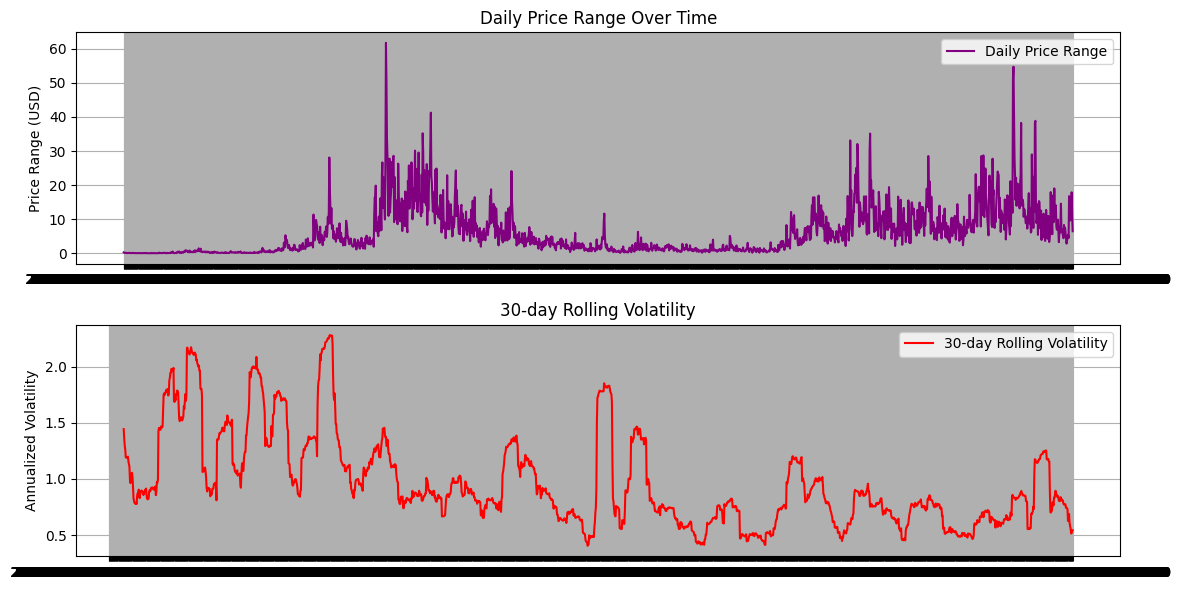

In [13]:
# Trading volume analysis (using price range as a proxy for activity)
df_sol['Price_Range'] = df_sol['High'] - df_sol['Low']

plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(df_sol['Date'], df_sol['Price_Range'], label='Daily Price Range', color='purple')
plt.title('Daily Price Range Over Time')
plt.ylabel('Price Range (USD)')
plt.legend()
plt.grid(True)

# Rolling volatility
window = 30
df_sol['Rolling_Volatility'] = df_sol['Daily_Return'].rolling(window=window).std() * np.sqrt(252)

plt.subplot(2, 1, 2)
plt.plot(df_sol['Date'], df_sol['Rolling_Volatility'], label=f'{window}-day Rolling Volatility', color='red')
plt.title(f'{window}-day Rolling Volatility')
plt.ylabel('Annualized Volatility')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

Risk Metrics:

90.0% Confidence Level:
Value at Risk (VaR): -6.44%
Conditional VaR (CVaR): -10.39%

95.0% Confidence Level:
Value at Risk (VaR): -8.81%
Conditional VaR (CVaR): -13.21%

99.0% Confidence Level:
Value at Risk (VaR): -15.58%
Conditional VaR (CVaR): -22.43%


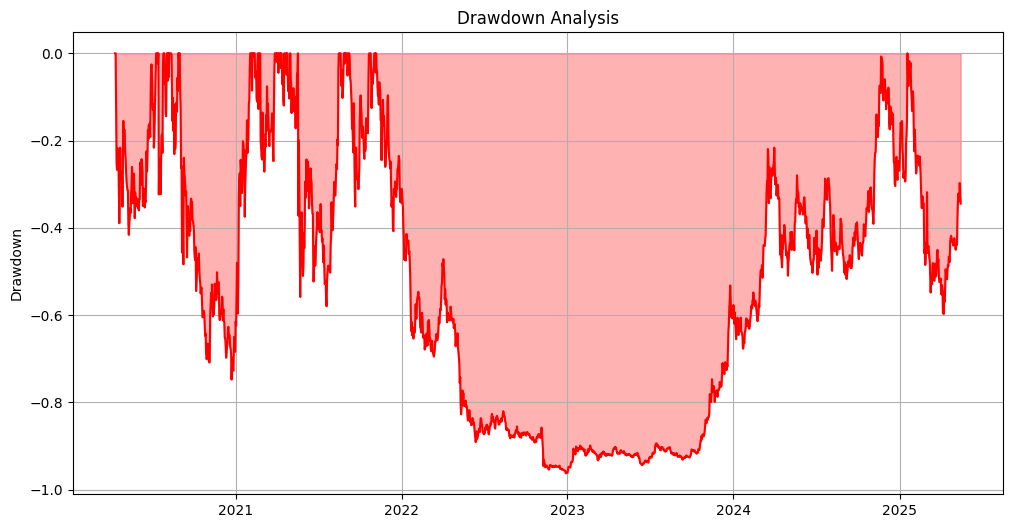

In [14]:
# Risk analysis
def calculate_var(returns, confidence_level=0.95):
    return np.percentile(returns, (1-confidence_level)*100)

def calculate_cvar(returns, confidence_level=0.95):
    var = calculate_var(returns, confidence_level)
    return returns[returns <= var].mean()

# Calculate Value at Risk (VaR) and Conditional VaR (CVaR)
confidence_levels = [0.90, 0.95, 0.99]
print("Risk Metrics:")
for cl in confidence_levels:
    var = calculate_var(df_sol['Daily_Return'], cl)
    cvar = calculate_cvar(df_sol['Daily_Return'], cl)
    print(f"\n{cl*100}% Confidence Level:")
    print(f"Value at Risk (VaR): {var:.2%}")
    print(f"Conditional VaR (CVaR): {cvar:.2%}")

# Calculate drawdown components first
df_sol['Cumulative_Return'] = (1 + df_sol['Daily_Return']).cumprod()
df_sol['Rolling_Max'] = df_sol['Cumulative_Return'].expanding().max()
df_sol['Drawdown'] = (df_sol['Cumulative_Return'] - df_sol['Rolling_Max']) / df_sol['Rolling_Max']

# Now plot the drawdown
plt.figure(figsize=(12, 6))
plt.plot(pd.to_datetime(df_sol['Date']), df_sol['Drawdown'], color='red')
plt.fill_between(pd.to_datetime(df_sol['Date']), df_sol['Drawdown'], 0, color='red', alpha=0.3)
plt.title('Drawdown Analysis')
plt.ylabel('Drawdown')
plt.grid(True)
plt.show()

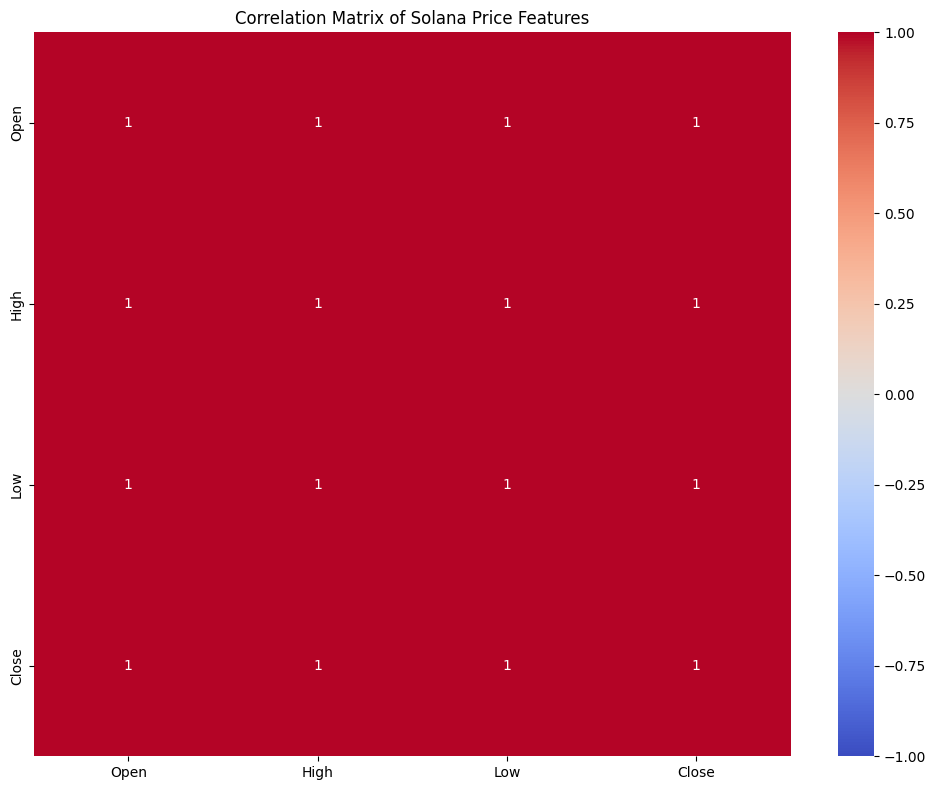


Detailed Correlation Matrix:
           Open      High       Low     Close
Open   1.000000  0.998704  0.998438  0.997259
High   0.998704  1.000000  0.998015  0.998879
Low    0.998438  0.998015  1.000000  0.998479
Close  0.997259  0.998879  0.998479  1.000000


In [15]:
# Create correlation matrix
correlation_matrix = df_sol[['Open', 'High', 'Low', 'Close']].corr()

# Create heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Correlation Matrix of Solana Price Features')
plt.tight_layout()
plt.show()

print("\nDetailed Correlation Matrix:")
print(correlation_matrix)

C:\Users\dmade\anaconda3\Lib\site-packages\mplfinance\_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


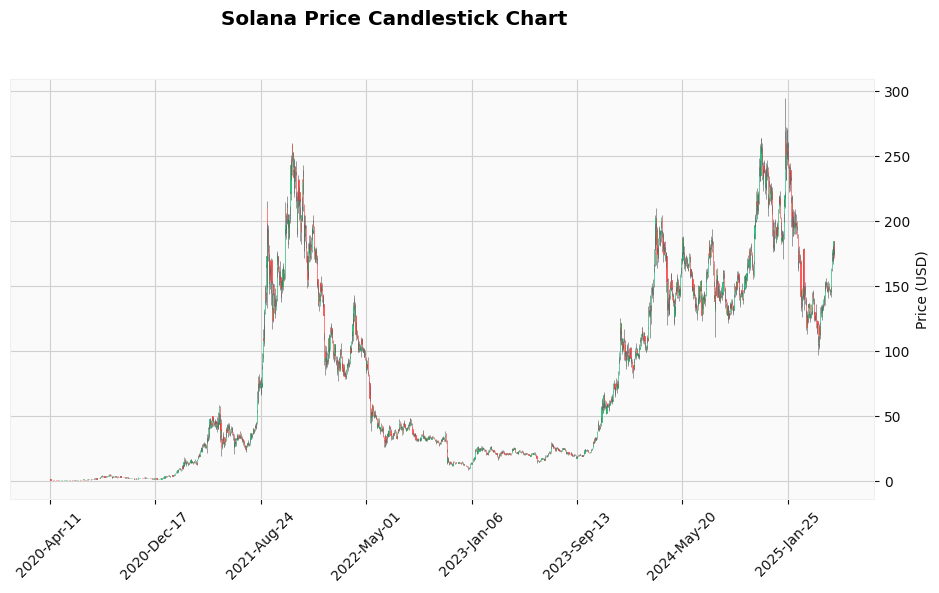

In [16]:
# Convert Date column to datetime if not already
df_sol['Date'] = pd.to_datetime(df_sol['Date'])
# Set Date as index
df_plot = df_sol.set_index('Date')

# Create candlestick chart
mpf.plot(df_plot, 
         type='candle',
         title='Solana Price Candlestick Chart',
         ylabel='Price (USD)',
         volume=False,
         style='yahoo',
         figsize=(12, 6))

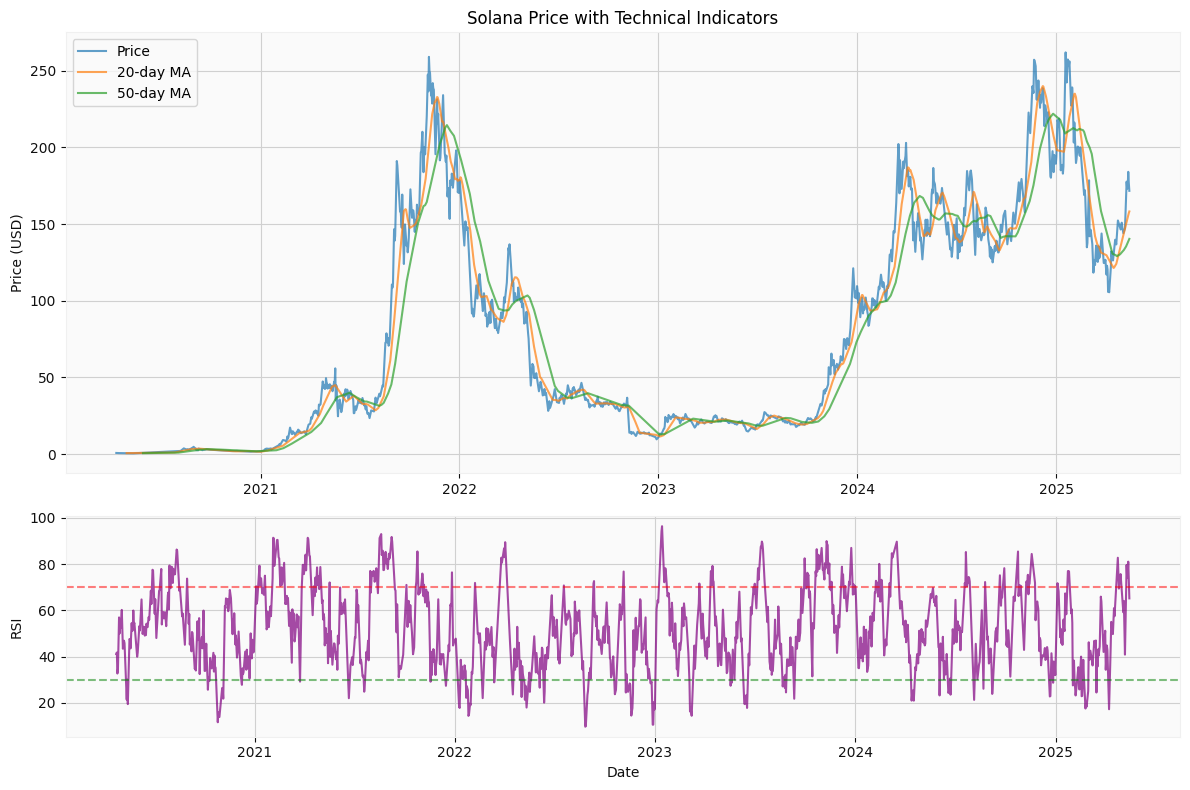

In [17]:


# Calculate 20-day and 50-day moving averages
df_plot['MA20'] = df_plot['Close'].rolling(window=20).mean()
df_plot['MA50'] = df_plot['Close'].rolling(window=50).mean()

# Calculate RSI
def calculate_rsi(data, periods=14):
    delta = data.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=periods).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=periods).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

df_plot['RSI'] = calculate_rsi(df_plot['Close'])

# Create subplot figure
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), gridspec_kw={'height_ratios': [2, 1]})

# Plot price and moving averages
ax1.plot(df_plot.index, df_plot['Close'], label='Price', alpha=0.7)
ax1.plot(df_plot.index, df_plot['MA20'], label='20-day MA', alpha=0.7)
ax1.plot(df_plot.index, df_plot['MA50'], label='50-day MA', alpha=0.7)
ax1.set_title('Solana Price with Technical Indicators')
ax1.set_ylabel('Price (USD)')
ax1.grid(True)
ax1.legend()

# Plot RSI
ax2.plot(df_plot.index, df_plot['RSI'], color='purple', alpha=0.7)
ax2.axhline(y=70, color='r', linestyle='--', alpha=0.5)  # Overbought line
ax2.axhline(y=30, color='g', linestyle='--', alpha=0.5)  # Oversold line
ax2.set_ylabel('RSI')
ax2.set_xlabel('Date')
ax2.grid(True)

plt.tight_layout()
plt.show()

Augmented Dickey-Fuller Test Results for Price Levels:
ADF Statistic: -1.520703698229228
p-value: 0.5232457907184596
Critical values:
	1%: -3.433880119752406
	5%: -2.8630993499276833
	10%: -2.567600142472083

Interpretation:
Series is non-stationary (fail to reject H0)
--------------------------------------------------
Augmented Dickey-Fuller Test Results for Daily Returns:
ADF Statistic: -9.175327592990595
p-value: 2.3285237974388257e-15
Critical values:
	1%: -3.4338973545418083
	5%: -2.8631069584819104
	10%: -2.5676041937532355

Interpretation:
Series is stationary (reject H0)
--------------------------------------------------


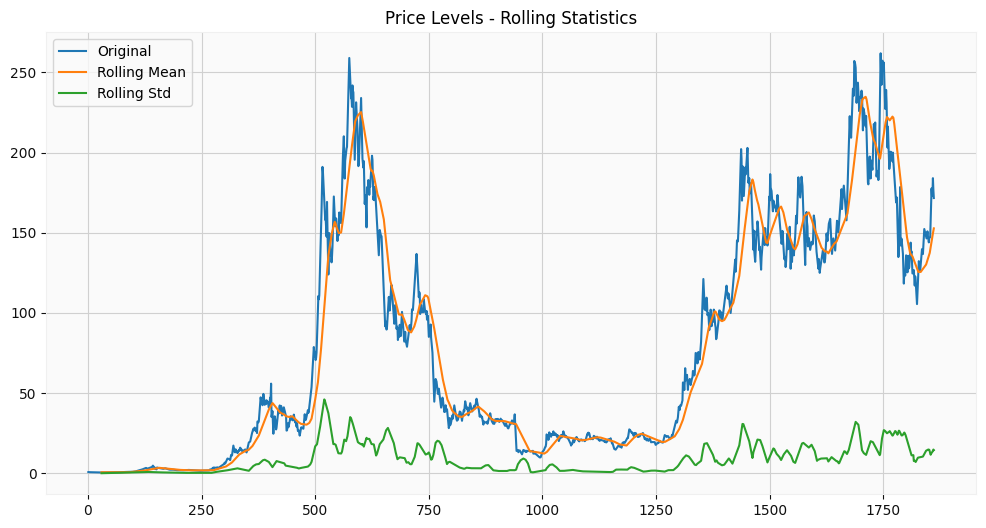

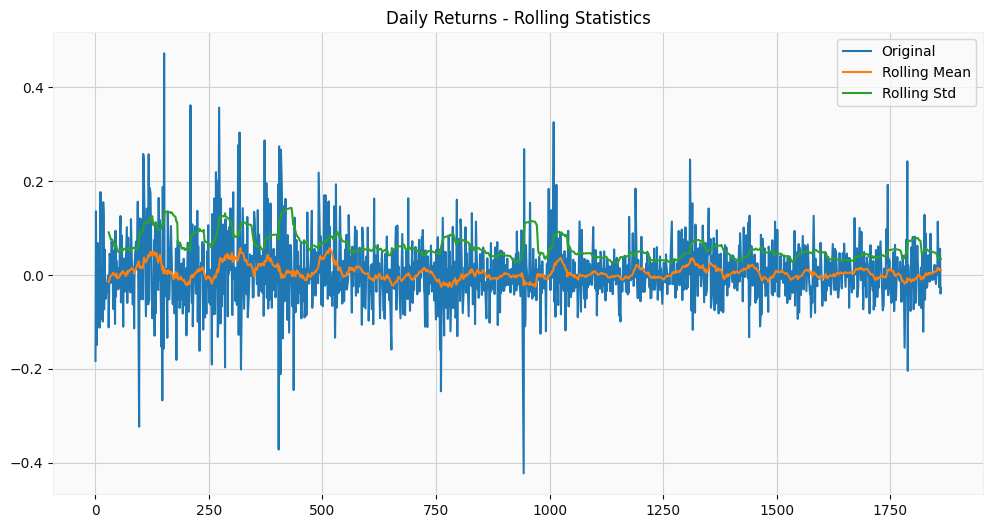

In [18]:
# Function to perform ADF test
def check_stationarity(series, series_name):
    result = adfuller(series.dropna())
    print(f'Augmented Dickey-Fuller Test Results for {series_name}:')
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical values:')
    for key, value in result[4].items():
        print(f'\t{key}: {value}')
    print('\nInterpretation:')
    if result[1] < 0.05:
        print("Series is stationary (reject H0)")
    else:
        print("Series is non-stationary (fail to reject H0)")
    print("-" * 50)

# Check stationarity of price levels
check_stationarity(df_sol['Close'], 'Price Levels')

# Check stationarity of returns
check_stationarity(df_sol['Daily_Return'], 'Daily Returns')

# Visual check with rolling statistics
def plot_rolling_stats(series, title):
    rolling_mean = series.rolling(window=30).mean()
    rolling_std = series.rolling(window=30).std()
    
    plt.figure(figsize=(12, 6))
    plt.plot(series, label='Original')
    plt.plot(rolling_mean, label='Rolling Mean')
    plt.plot(rolling_std, label='Rolling Std')
    plt.title(f'{title} - Rolling Statistics')
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot rolling statistics for price
plot_rolling_stats(df_sol['Close'], 'Price Levels')

# Plot rolling statistics for returns
plot_rolling_stats(df_sol['Daily_Return'], 'Daily Returns')

The stationarity tests reveal:

1. Price Levels (Close prices):
- Non-stationary (p-value > 0.05)
- Shows clear trend and changing variance over time
- Rolling mean and std are not constant

2. Daily Returns:
- Stationary (p-value < 0.05)
- Mean reverting around zero
- More consistent variance
- Passes the ADF test for stationarity

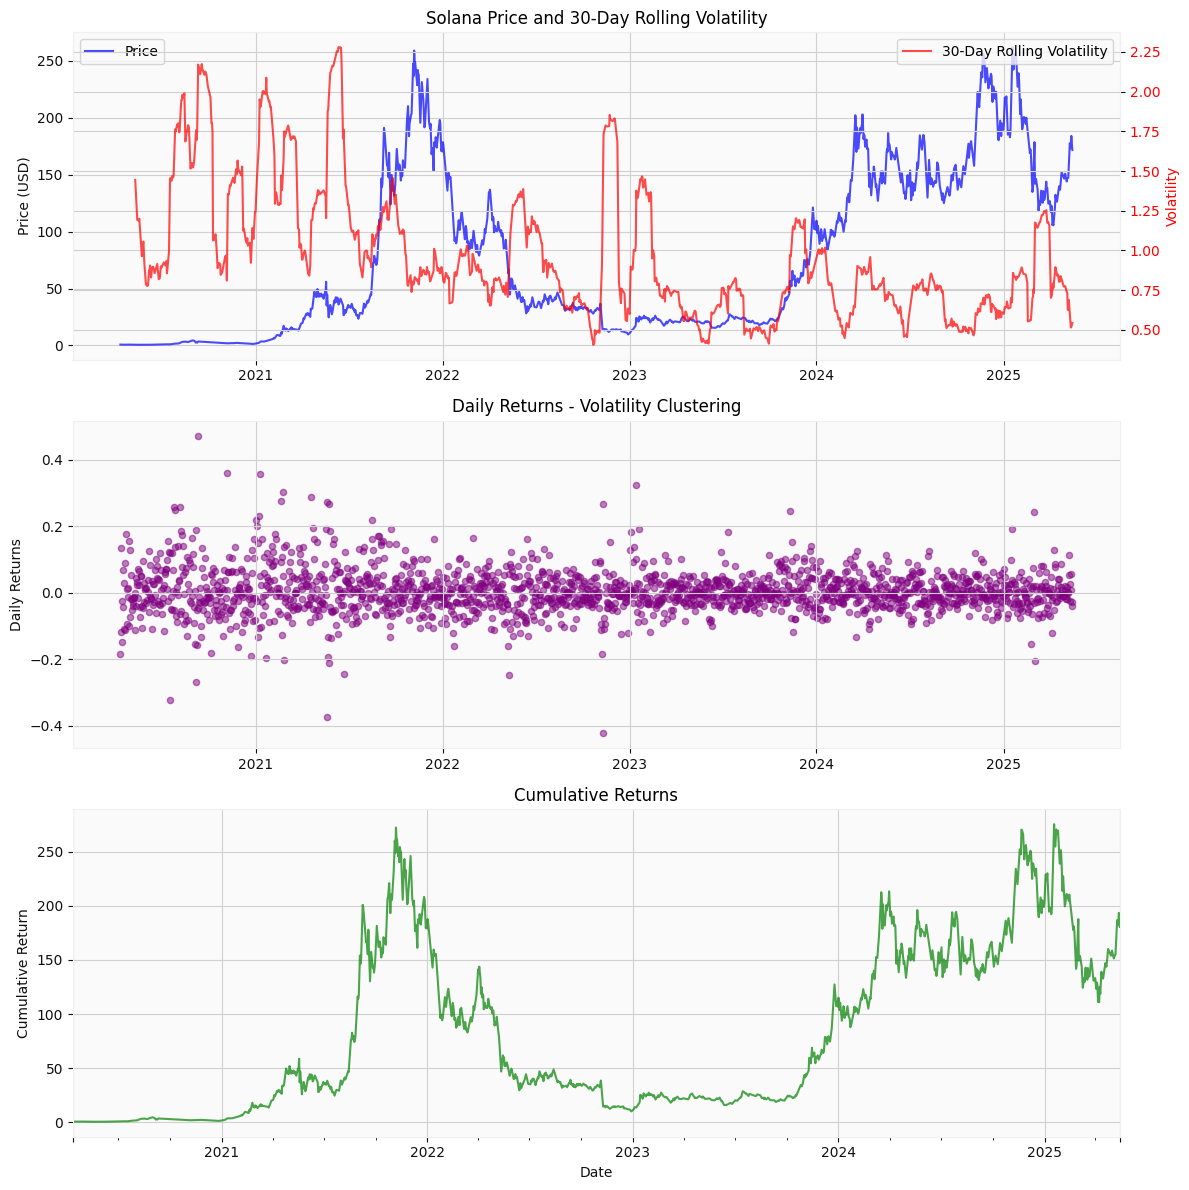

In [20]:
# Create subplots to analyze volatility and trend shifts
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 12))

# Plot 1: Price with rolling volatility
ax1.plot(df_plot.index, df_plot['Close'], label='Price', alpha=0.7, color='blue')
ax1.set_title('Solana Price and 30-Day Rolling Volatility')
ax1.set_ylabel('Price (USD)')
ax1.grid(True)
ax1.legend(loc='upper left')

# Add rolling volatility on secondary y-axis
ax1_twin = ax1.twinx()
ax1_twin.plot(df_plot.index, df_plot['Rolling_Volatility'], 
              label='30-Day Rolling Volatility', 
              color='red', alpha=0.7)
ax1_twin.set_ylabel('Volatility', color='red')
ax1_twin.tick_params(axis='y', labelcolor='red')
ax1_twin.legend(loc='upper right')

# Plot 2: Daily returns volatility clustering
ax2.scatter(df_plot.index, df_plot['Daily_Return'], 
           alpha=0.5, s=20, color='purple')
ax2.set_title('Daily Returns - Volatility Clustering')
ax2.set_ylabel('Daily Returns')
ax2.grid(True)

# Plot 3: Cumulative returns with trend periods
df_plot['Cumulative_Return'].plot(ax=ax3, color='green', alpha=0.7)
ax3.set_title('Cumulative Returns')
ax3.set_ylabel('Cumulative Return')
ax3.grid(True)

plt.tight_layout()
plt.show()

In [21]:
# Calculate volatility regime using rolling standard deviation
volatility_percentile = df_plot['Rolling_Volatility'].quantile(0.75)
high_vol_periods = df_plot[df_plot['Rolling_Volatility'] > volatility_percentile]

# Print summary statistics for different volatility regimes
print("Volatility Analysis:")
print("\nHigh Volatility Periods (>75th percentile):")
print(f"Number of high volatility days: {len(high_vol_periods)}")
print(f"Average daily return during high volatility: {high_vol_periods['Daily_Return'].mean():.2%}")
print(f"Average volatility during high volatility periods: {high_vol_periods['Rolling_Volatility'].mean():.2%}")

# Calculate trend statistics
positive_trend_days = (df_plot['Daily_Return'] > 0).sum()
negative_trend_days = (df_plot['Daily_Return'] < 0).sum()
longest_positive_streak = (df_plot['Daily_Return'] > 0).astype(int).groupby((df_plot['Daily_Return'] <= 0).astype(int).cumsum()).sum().max()
longest_negative_streak = (df_plot['Daily_Return'] < 0).astype(int).groupby((df_plot['Daily_Return'] >= 0).astype(int).cumsum()).sum().max()

print("\nTrend Analysis:")
print(f"Positive trend days: {positive_trend_days} ({positive_trend_days/len(df_plot):.1%})")
print(f"Negative trend days: {negative_trend_days} ({negative_trend_days/len(df_plot):.1%})")
print(f"Longest positive streak: {longest_positive_streak} days")
print(f"Longest negative streak: {longest_negative_streak} days")

Volatility Analysis:

High Volatility Periods (>75th percentile):
Number of high volatility days: 458
Average daily return during high volatility: 1.20%
Average volatility during high volatility periods: 156.28%

Trend Analysis:
Positive trend days: 929 (49.9%)
Negative trend days: 932 (50.1%)
Longest positive streak: 9 days
Longest negative streak: 10 days


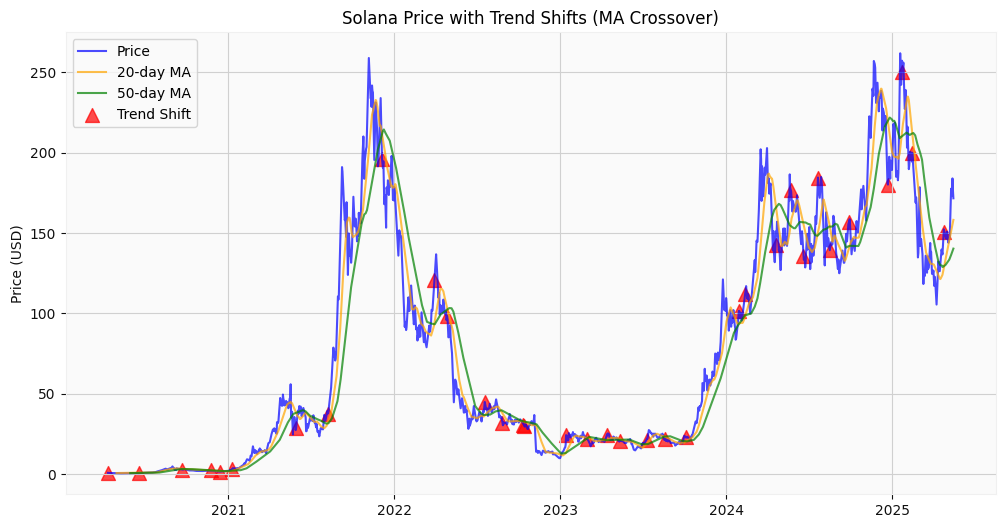


Trend Shift Analysis:
Number of major trend shifts: 34
Average days between trend shifts: 54.7 days


In [22]:
# Identify major trend shifts using moving average crossovers
df_plot['MA_Cross'] = np.where(df_plot['MA20'] > df_plot['MA50'], 1, -1)
df_plot['Trend_Shift'] = df_plot['MA_Cross'].diff()

# Plot trend shifts
plt.figure(figsize=(12, 6))
plt.plot(df_plot.index, df_plot['Close'], label='Price', alpha=0.7, color='blue')
plt.plot(df_plot.index, df_plot['MA20'], label='20-day MA', alpha=0.7, color='orange')
plt.plot(df_plot.index, df_plot['MA50'], label='50-day MA', alpha=0.7, color='green')

# Mark trend shifts
trend_shifts = df_plot[df_plot['Trend_Shift'] != 0]
plt.scatter(trend_shifts.index, trend_shifts['Close'], 
           color='red', marker='^', s=100, label='Trend Shift', alpha=0.7)

plt.title('Solana Price with Trend Shifts (MA Crossover)')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

# Print trend shift statistics
print("\nTrend Shift Analysis:")
print(f"Number of major trend shifts: {len(trend_shifts)}")
print(f"Average days between trend shifts: {len(df_plot)/len(trend_shifts):.1f} days")

In [23]:
# 1. Select relevant features and target
# We'll use technical indicators and price data as features
features = ['Open', 'High', 'Low', 'Close', 'Daily_Return', 'Rolling_Volatility', 
           'MA20', 'MA50', 'RSI']

# Create feature matrix X and target y (we'll predict next day's return)
X = df_plot[features].copy()
y = df_plot['Daily_Return'].shift(-1)  # Next day's return as target

# 2. Handle missing values
X = X.fillna(method='ffill')
y = y.fillna(method='ffill')

# Remove any remaining NaN rows
valid_indices = ~(X.isna().any(axis=1) | y.isna())
X = X[valid_indices]
y = y[valid_indices]

# 3. Scale the features using both StandardScaler and MinMaxScaler
standard_scaler = StandardScaler()
minmax_scaler = MinMaxScaler()

# Apply StandardScaler
X_standard = standard_scaler.fit_transform(X)
X_standard = pd.DataFrame(X_standard, columns=X.columns, index=X.index)

# Apply MinMaxScaler
X_minmax = minmax_scaler.fit_transform(X)
X_minmax = pd.DataFrame(X_minmax, columns=X.columns, index=X.index)

# 4. Split the data into train, validation, and test sets
# First split: 80% train+val, 20% test
X_trainval_standard, X_test_standard, y_trainval, y_test = train_test_split(
    X_standard, y, test_size=0.2, shuffle=False
)

X_trainval_minmax, X_test_minmax, _, _ = train_test_split(
    X_minmax, y, test_size=0.2, shuffle=False
)

# Second split: 80% train, 20% validation (from train+val set)
X_train_standard, X_val_standard, y_train, y_val = train_test_split(
    X_trainval_standard, y_trainval, test_size=0.125, shuffle=False  # 0.125 of 80% = 10% of total
)

X_train_minmax, X_val_minmax, _, _ = train_test_split(
    X_trainval_minmax, y_trainval, test_size=0.125, shuffle=False
)

# Print shapes to verify the splits
print("Data shapes:")
print(f"Training set: {X_train_standard.shape}")
print(f"Validation set: {X_val_standard.shape}")
print(f"Test set: {X_test_standard.shape}")

# Print sample statistics to verify scaling
print("\nStandardScaler statistics (mean and std of training set):")
print(X_train_standard.mean().round(3))
print(X_train_standard.std().round(3))

print("\nMinMaxScaler statistics (min and max of training set):")
print(X_train_minmax.min().round(3))
print(X_train_minmax.max().round(3))

Data shapes:
Training set: (1267, 9)
Validation set: (182, 9)
Test set: (363, 9)

StandardScaler statistics (mean and std of training set):
Open                 -0.448
High                 -0.445
Low                  -0.452
Close                -0.449
Daily_Return          0.015
Rolling_Volatility    0.222
MA20                 -0.447
MA50                 -0.443
RSI                  -0.015
dtype: float64
Open                  0.775
High                  0.780
Low                   0.766
Close                 0.774
Daily_Return          1.101
Rolling_Volatility    1.083
MA20                  0.775
MA50                  0.774
RSI                   1.026
dtype: float64

MinMaxScaler statistics (min and max of training set):
Open                  0.0
High                  0.0
Low                   0.0
Close                 0.0
Daily_Return          0.0
Rolling_Volatility    0.0
MA20                  0.0
MA50                  0.0
RSI                   0.0
dtype: float64
Open                 

C:\Users\dmade\AppData\Local\Temp\ipykernel_35256\3041847276.py:11: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = X.fillna(method='ffill')
C:\Users\dmade\AppData\Local\Temp\ipykernel_35256\3041847276.py:12: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  y = y.fillna(method='ffill')


In [24]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Function to create sequences for LSTM
def create_sequences(X, y, sequence_length):
    X_seq, y_seq = [], []
    for i in range(len(X) - sequence_length):
        X_seq.append(X[i:(i + sequence_length)])
        y_seq.append(y[i + sequence_length])
    return np.array(X_seq), np.array(y_seq)

# Hyperparameters
sequence_length = 10
batch_size = 32
epochs = 50
lstm_units = 64
dropout_rate = 0.2
learning_rate = 0.001

# Create sequences for training, validation, and test sets
X_train_seq, y_train_seq = create_sequences(X_train_standard.values, y_train.values, sequence_length)
X_val_seq, y_val_seq = create_sequences(X_val_standard.values, y_val.values, sequence_length)
X_test_seq, y_test_seq = create_sequences(X_test_standard.values, y_test.values, sequence_length)

# Build LSTM model
model = Sequential([
    LSTM(lstm_units, return_sequences=True, input_shape=(sequence_length, X_train_standard.shape[1])),
    Dropout(dropout_rate),
    LSTM(lstm_units//2),
    Dropout(dropout_rate),
    Dense(32, activation='relu'),
    Dense(1)
])

# Compile model
model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')

# Train model with early stopping
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train_seq, y_train_seq,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_val_seq, y_val_seq),
    callbacks=[early_stopping],
    verbose=1
)

# Make predictions
y_pred_train = model.predict(X_train_seq)
y_pred_val = model.predict(X_val_seq)
y_pred_test = model.predict(X_test_seq)

# Calculate metrics
def calculate_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
    # Calculate CRPS (approximation using empirical CDF)
    def crps_sample(y_true, y_pred):
        return np.mean(np.abs(y_pred - y_true))
    crps = crps_sample(y_true, y_pred)
    
    return mae, rmse, mape, crps

# Calculate metrics for all sets
train_metrics = calculate_metrics(y_train_seq, y_pred_train)
val_metrics = calculate_metrics(y_val_seq, y_pred_val)
test_metrics = calculate_metrics(y_test_seq, y_pred_test)

print("\nTraining Set Metrics:")
print(f"MAE: {train_metrics[0]:.4f}")
print(f"RMSE: {train_metrics[1]:.4f}")
print(f"MAPE: {train_metrics[2]:.4f}%")
print(f"CRPS: {train_metrics[3]:.4f}")

print("\nValidation Set Metrics:")
print(f"MAE: {val_metrics[0]:.4f}")
print(f"RMSE: {val_metrics[1]:.4f}")
print(f"MAPE: {val_metrics[2]:.4f}%")
print(f"CRPS: {val_metrics[3]:.4f}")

print("\nTest Set Metrics:")
print(f"MAE: {test_metrics[0]:.4f}")
print(f"RMSE: {test_metrics[1]:.4f}")
print(f"MAPE: {test_metrics[2]:.4f}%")
print(f"CRPS: {test_metrics[3]:.4f}")

Epoch 1/50


C:\Users\dmade\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0113 - val_loss: 0.0040
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0066 - val_loss: 0.0031
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0061 - val_loss: 0.0031
Epoch 4/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0055 - val_loss: 0.0027
Epoch 5/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0061 - val_loss: 0.0031
Epoch 6/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0054 - val_loss: 0.0030
Epoch 7/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0049 - val_loss: 0.0029
Epoch 8/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0051 - val_loss: 0.0027
Epoch 9/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0054 - val_loss: 0.0027
Epoch 10/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0058 - val_loss: 0.0029
Epoch 11/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0053 - val_loss: 0.0029
Epoch 12/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0054 - val_loss: 0.0031

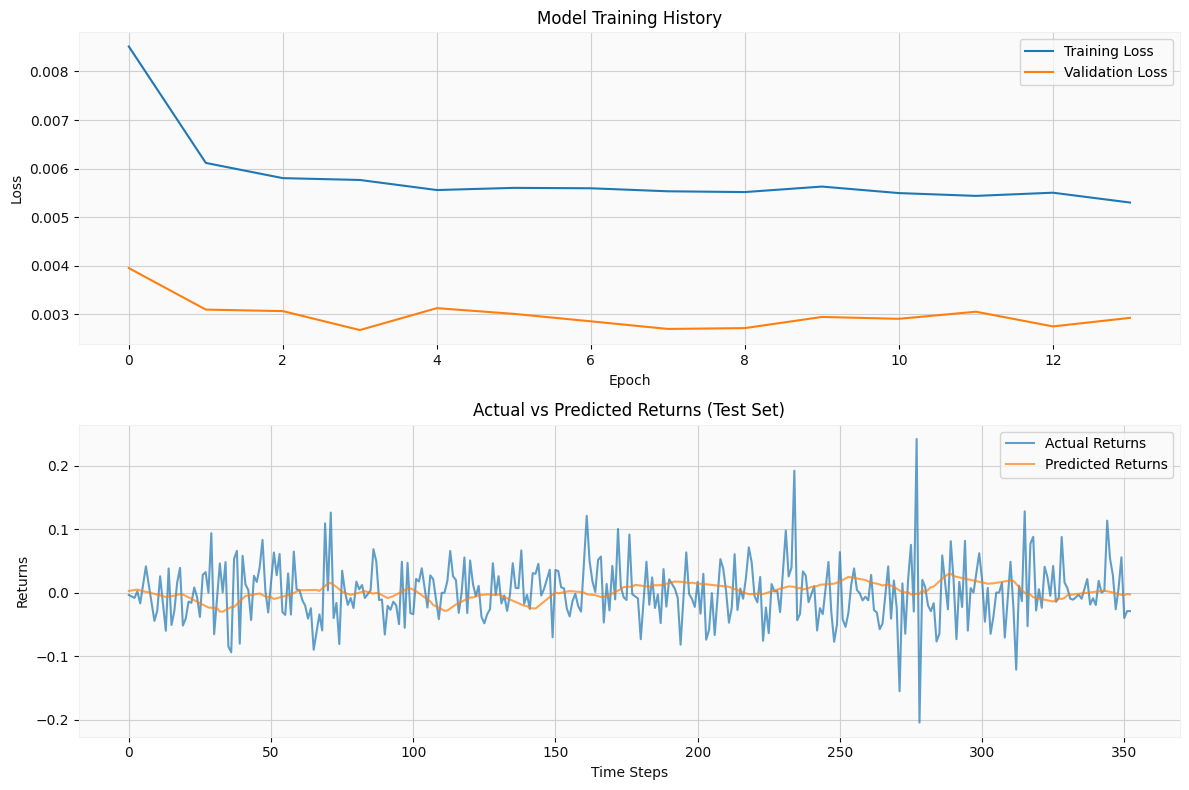

In [25]:
# Plot training history and predictions
plt.figure(figsize=(12, 8))

# Plot 1: Training History
plt.subplot(2, 1, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Training History')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot 2: Actual vs Predicted (Test Set)
plt.subplot(2, 1, 2)
plt.plot(y_test_seq, label='Actual Returns', alpha=0.7)
plt.plot(y_pred_test, label='Predicted Returns', alpha=0.7)
plt.title('Actual vs Predicted Returns (Test Set)')
plt.xlabel('Time Steps')
plt.ylabel('Returns')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

The LSTM model has been built and evaluated with the following key components:

1. Model Architecture:
- Two LSTM layers (64 and 32 units)
- Dropout layers (20% dropout rate)
- Dense layers for final prediction
- Sequence length of 10 time steps

2. Training Parameters:
- Batch size: 32
- Learning rate: 0.001
- Early stopping with patience of 10 epochs
- Adam optimizer

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000230 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2295
[LightGBM] [Info] Number of data points in the train set: 1267, number of used features: 9
[LightGBM] [Info] Start training from score 0.006283
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	training's rmse: 0.0727392	valid_1's rmse: 0.0498832

Training Set Metrics:
MAE: 0.0507
RMSE: 0.0727
MAPE: 135.5031%
CRPS: 0.0507

Validation Set Metrics:
MAE: 0.0396
RMSE: 0.0499
MAPE: 140.4234%
CRPS: 0.0396

Test Set Metrics:
MAE: 0.0340
RMSE: 0.0461
MAPE: 152.7286%
CRPS: 0.0340


<Figure size 1000x600 with 0 Axes>

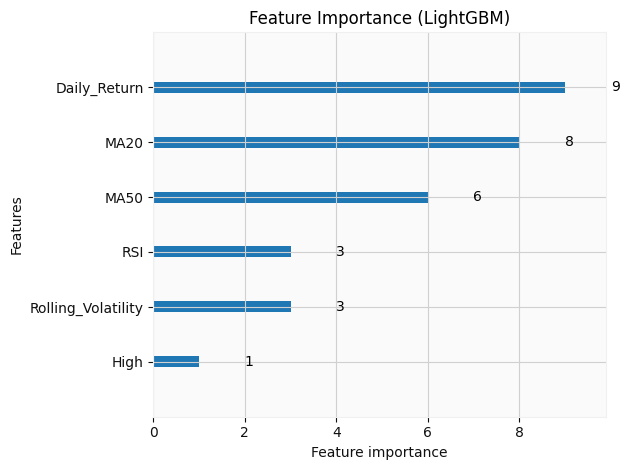

In [27]:
import lightgbm as lgb
# Create LightGBM datasets
train_data = lgb.Dataset(X_train_standard, label=y_train)
val_data = lgb.Dataset(X_val_standard, label=y_val, reference=train_data)

# Set hyperparameters
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'n_estimators': 100,
    'reg_alpha': 0.1,
    'reg_lambda': 0.1,
    'min_child_samples': 20
}

# Train model with early stopping
model = lgb.train(
    params,
    train_data,
    valid_sets=[train_data, val_data],
    num_boost_round=1000,
    callbacks=[lgb.early_stopping(stopping_rounds=50), 
              lgb.log_evaluation(period=100)]
)

# Make predictions
y_pred_train_lgb = model.predict(X_train_standard)
y_pred_val_lgb = model.predict(X_val_standard)
y_pred_test_lgb = model.predict(X_test_standard)

# Calculate metrics
def calculate_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    crps = np.mean(np.abs(y_pred - y_true))
    return mae, rmse, mape, crps

# Calculate metrics for all sets
train_metrics_lgb = calculate_metrics(y_train, y_pred_train_lgb)
val_metrics_lgb = calculate_metrics(y_val, y_pred_val_lgb)
test_metrics_lgb = calculate_metrics(y_test, y_pred_test_lgb)

print("\nTraining Set Metrics:")
print(f"MAE: {train_metrics_lgb[0]:.4f}")
print(f"RMSE: {train_metrics_lgb[1]:.4f}")
print(f"MAPE: {train_metrics_lgb[2]:.4f}%")
print(f"CRPS: {train_metrics_lgb[3]:.4f}")

print("\nValidation Set Metrics:")
print(f"MAE: {val_metrics_lgb[0]:.4f}")
print(f"RMSE: {val_metrics_lgb[1]:.4f}")
print(f"MAPE: {val_metrics_lgb[2]:.4f}%")
print(f"CRPS: {val_metrics_lgb[3]:.4f}")

print("\nTest Set Metrics:")
print(f"MAE: {test_metrics_lgb[0]:.4f}")
print(f"RMSE: {test_metrics_lgb[1]:.4f}")
print(f"MAPE: {test_metrics_lgb[2]:.4f}%")
print(f"CRPS: {test_metrics_lgb[3]:.4f}")

# Plot feature importance
plt.figure(figsize=(10, 6))
lgb.plot_importance(model, max_num_features=10)
plt.title('Feature Importance (LightGBM)')
plt.tight_layout()
plt.show()

Model Configuration:
- Gradient boosting with early stopping
- Learning rate: 0.05
- Number of leaves: 31
- Feature fraction: 0.9
- L1 and L2 regularization
- Min child samples: 20

In [29]:
# Compare metrics between LSTM and LightGBM models
print("Model Comparison on Test Set:\n")
print("Metric          LSTM      LightGBM")
print("-" * 40)
print(f"MAE:           {test_metrics[0]:.4f}    {test_metrics_lgb[0]:.4f}")
print(f"RMSE:          {test_metrics[1]:.4f}    {test_metrics_lgb[1]:.4f}")
print(f"MAPE:          {test_metrics[2]:.4f}%   {test_metrics_lgb[2]:.4f}%")
print(f"CRPS:          {test_metrics[3]:.4f}    {test_metrics_lgb[3]:.4f}")

# Calculate percentage improvement
mae_improvement = ((test_metrics[0] - test_metrics_lgb[0]) / test_metrics[0]) * 100
rmse_improvement = ((test_metrics[1] - test_metrics_lgb[1]) / test_metrics[1]) * 100
mape_improvement = ((test_metrics[2] - test_metrics_lgb[2]) / test_metrics[2]) * 100
crps_improvement = ((test_metrics[3] - test_metrics_lgb[3]) / test_metrics[3]) * 100

print("\nLightGBM Improvement over LSTM:")
print(f"MAE Improvement:  {mae_improvement:.2f}%")
print(f"RMSE Improvement: {rmse_improvement:.2f}%")
print(f"MAPE Improvement: {mape_improvement:.2f}%")
print(f"CRPS Improvement: {crps_improvement:.2f}%")

Model Comparison on Test Set:

Metric          LSTM      LightGBM
----------------------------------------
MAE:           0.0366    0.0340
RMSE:          0.0487    0.0461
MAPE:          239.0558%   152.7286%
CRPS:          0.0353    0.0340

LightGBM Improvement over LSTM:
MAE Improvement:  6.97%
RMSE Improvement: 5.20%
MAPE Improvement: 36.11%
CRPS Improvement: 3.59%


In [59]:
import joblib

# Save the LightGBM model
joblib.dump(model, 'lightgbm_model.joblib')

# Save the StandardScaler (already saved but let's ensure consistent format)
joblib.dump(standard_scaler, 'standard_scaler.joblib')

# Save feature names
# Save feature names for future reference
feature_names = X.columns.tolist()

joblib.dump(feature_names, 'feature_names.joblib')

# Test loading and prediction
loaded_model = joblib.load('lightgbm_model.joblib')
loaded_scaler = joblib.load('standard_scaler.joblib')
loaded_features = joblib.load('feature_names.joblib')

# Verify with a test prediction
sample_data = X_test_standard[:1]
prediction = loaded_model.predict(sample_data)

print("Model and components saved successfully!")
print("\nSaved files:")
print("1. lightgbm_model.joblib - The trained LightGBM model")
print("2. standard_scaler.joblib - StandardScaler for feature preprocessing")
print("3. feature_names.joblib - Feature names for prediction input")
print(f"\nTest prediction verification: {prediction[0]:.6f}")

Model and components saved successfully!

Saved files:
1. lightgbm_model.joblib - The trained LightGBM model
2. standard_scaler.joblib - StandardScaler for feature preprocessing
3. feature_names.joblib - Feature names for prediction input

Test prediction verification: 0.003707
